<a href="https://colab.research.google.com/github/lcjln/Kaggle_HousePrice/blob/main/House_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name = fn, length = len(uploaded[fn])))

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions list

ref                                                                              deadline             category                reward  teamCount  userHasEntered  
-------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/arc-prize-2025                               2025-11-03 23:59:00  Featured         1,000,000 Usd        657           False  
https://www.kaggle.com/competitions/google-gemma-3n-hackathon                    2025-08-06 23:59:00  Featured           150,000 Usd          0           False  
https://www.kaggle.com/competitions/make-data-count-finding-data-references      2025-09-09 23:59:00  Research           100,000 Usd        607           False  
https://www.kaggle.com/competitions/map-charting-student-math-misunderstandings  2025-10-15 23:59:00  Featured            55,000 Usd        242           False  
https://www.kaggle.com/compe

In [5]:
#!kaggle competitions download -c house-prices-advanced-regression-techniques

In [6]:
#기본 패키지
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
#plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import tensorflow as tf
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [8]:
train.shape

(1460, 81)

In [9]:
test.shape

(1459, 80)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

이상치 제거하기

OverallQual, OverallCond -> 설문조사의 주관적인 편향성이 드러날 가능성이 있음

In [12]:
train.drop(train[(train['OverallQual']<4) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['OverallCond']<4) & (train['SalePrice']>200000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)
print(train.shape)

(1458, 81)


종속 변수 로그 변환

The value of mu before log transformation is: 180761.24142661178
The value of sigma before log transformation is: 79270.93617295024


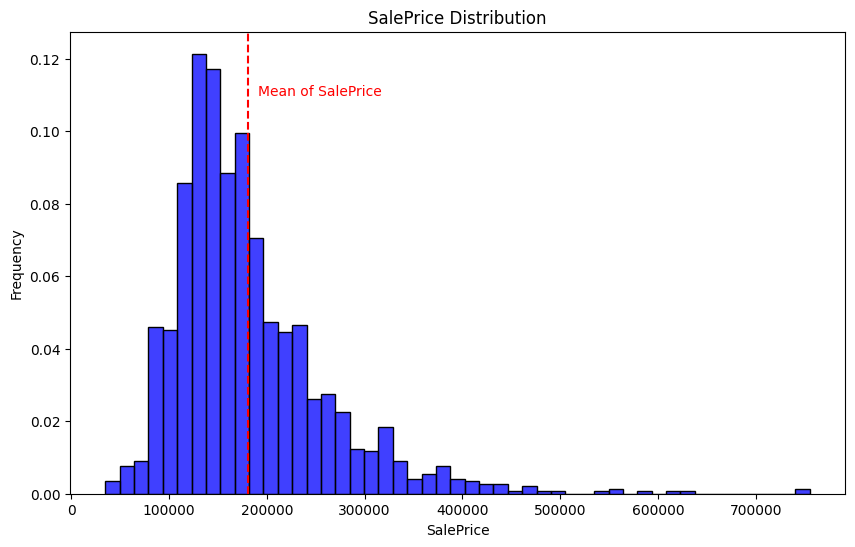

In [13]:
(mu, sigma) = stats.norm.fit(train['SalePrice']) #MLE를 이용하여 평균(mu)와 표준편차(sigma)를 구함
print("The value of mu before log transformation is:", mu)
print("The value of sigma before log transformation is:", sigma)

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(train['SalePrice'], color = 'b', stat = "probability") # y축은 절댓값이 아닌 비율로 표현
ax.xaxis.grid(False) #눈금선 제거
ax.set(ylabel = 'Frequency')
ax.set(xlabel = 'SalePrice')
ax.set(title = 'SalePrice Distribution')
plt.axvline(mu, color = 'r', linestyle = '--') # 평균에 수직선(axvline) 생성
plt.text(mu+10000, 0.11, 'Mean of SalePrice', rotation = 0, color = 'r') #평균 수직선 오른쪽(+10000)에 'Mean of SalePrice' 텍스트 표시 , 0.11은 y좌표
fig.show()

일반적인 회귀 분석은 정규 분포를 만족해야 한다

The value of mu after log transformation is: 12.0233397799989
The value of sigma after log transformation is: 0.3989191793099824


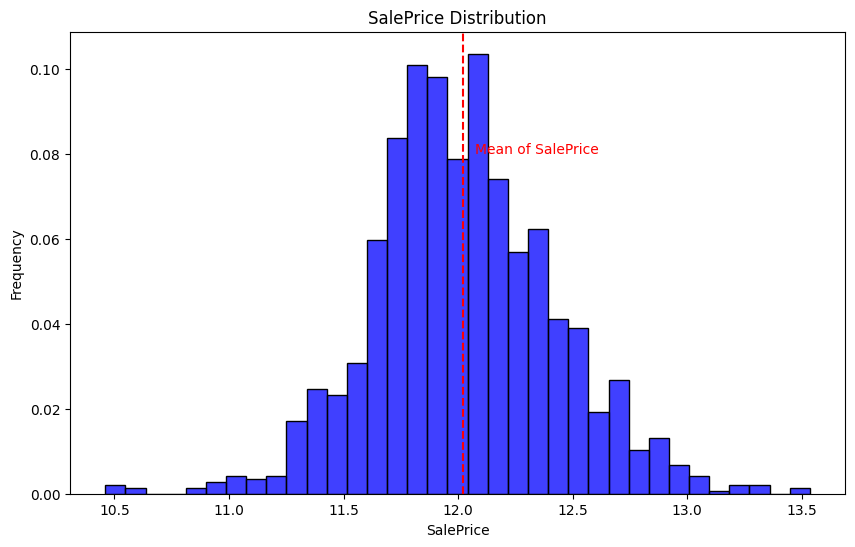

In [14]:
train['SalePrice'] = np.log1p(train['SalePrice']) # 로그변환 np.log보다 np.log1p가 더 정확함 (np.log = ln(x) // np.log1p = ln(1+x))

(mu, sigma) = stats.norm.fit(train['SalePrice']) #MLE를 이용하여 평균(mu)와 표준편차(sigma)를 구함
print("The value of mu after log transformation is:", mu)
print("The value of sigma after log transformation is:", sigma)

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(train['SalePrice'], color = 'b', stat = "probability") # y축은 절댓값이 아닌 비율로 표현
ax.xaxis.grid(False) #눈금선 제거
ax.set(ylabel = 'Frequency')
ax.set(xlabel = 'SalePrice')
ax.set(title = 'SalePrice Distribution')

plt.axvline(mu, color = 'r', linestyle = '--') # 평균에 수직선(axvline) 생성
plt.text(mu+0.05, 0.08, 'Mean of SalePrice', rotation = 0, color = 'r') #평균 수직선 오른쪽(+10000)에 'Mean of SalePrice' 텍스트 표시
fig.show()

# 데이터 합치기

In [15]:
train_ID = train['Id'] #입력 변수로 사용할 ID는 별도의 객체로 저장
test_ID = test['Id']
train.drop(['Id'], axis = 1, inplace = True)
test.drop(['Id'], axis = 1, inplace = True)
train.shape, test.shape

((1458, 80), (1459, 79))

In [16]:
y = train['SalePrice'].reset_index(drop = True) # y 변수로 사용할 SalePrice는 별도의 객체에 저장
train = train.drop(['SalePrice'], axis = 1)
train.shape, test.shape # 이제 변수의 개수가 동일함을 알 수 있음

((1458, 79), (1459, 79))

In [17]:
all_df = pd.concat([train,test]).reset_index(drop=True)
all_df.shape

(2917, 79)

# 결측치 처리하기

In [18]:
#결측치를 확인해 비율로 계산한 뒤 내림차순으로 정렬하는 사용자 정의 함수
def check_na(data, head_num = 6):
    isnull_na=(data.isnull().sum()/len(data))*100 # 데이터 별 결측치 비율 계산
    data_na = isnull_na.drop(isnull_na[isnull_na==0].index).sort_values(ascending = False) # 결측치가 없는 데이터는 출력되지 않게 하고 결측치 비율을 내림차순으로 정렬
    missing_data = pd.DataFrame({'Missing Ratio' : data_na,
                                 'Data Type' : data.dtypes[data_na.index]}) # 데이터프레임으로 정리
    print("결측치 데이터 칼럽과 건수:\n", missing_data.head(head_num))

In [19]:
check_na(all_df,20) # 결측치 비율을 확인하고 비율이 가장 많은 상위 7개 변수를 제거

결측치 데이터 칼럽과 건수:
               Missing Ratio Data Type
PoolQC            99.657182    object
MiscFeature       96.400411    object
Alley             93.212204    object
Fence             80.425094    object
MasVnrType        60.507371    object
FireplaceQu       48.680151    object
LotFrontage       16.626671   float64
GarageQual         5.450806    object
GarageYrBlt        5.450806   float64
GarageCond         5.450806    object
GarageFinish       5.450806    object
GarageType         5.382242    object
BsmtExposure       2.811107    object
BsmtCond           2.811107    object
BsmtQual           2.776826    object
BsmtFinType2       2.742544    object
BsmtFinType1       2.708262    object
MasVnrArea         0.754200   float64
MSZoning           0.137127    object
BsmtFullBath       0.068564   float64


In [20]:
all_df.drop(['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu','LotFrontage'], axis = 1, inplace = True)
check_na(all_df, 20)

결측치 데이터 칼럽과 건수:
               Missing Ratio Data Type
GarageFinish       5.450806    object
GarageCond         5.450806    object
GarageQual         5.450806    object
GarageYrBlt        5.450806   float64
GarageType         5.382242    object
BsmtExposure       2.811107    object
BsmtCond           2.811107    object
BsmtQual           2.776826    object
BsmtFinType2       2.742544    object
BsmtFinType1       2.708262    object
MasVnrArea         0.754200   float64
MSZoning           0.137127    object
BsmtHalfBath       0.068564   float64
BsmtFullBath       0.068564   float64
Utilities          0.068564    object
Functional         0.068564    object
BsmtFinSF1         0.034282   float64
Exterior1st        0.034282    object
Exterior2nd        0.034282    object
KitchenQual        0.034282    object


결측치 처리 - 문자열

In [21]:
#본 분석에서 문자열 데이터 결측치 처리는 빈도수 중 가장 높은 것으로 채워 넣는다
cat = list(all_df.select_dtypes(exclude = [np.number]))
print("The whole number of all_vars:", len(list(cat)))

for i in cat:
    all_df[i] = all_df[i].fillna(all_df[i].mode()[0])

The whole number of all_vars: 37


In [22]:
check_na(all_df, 20)

결측치 데이터 칼럽과 건수:
               Missing Ratio Data Type
GarageYrBlt        5.450806   float64
MasVnrArea         0.754200   float64
BsmtHalfBath       0.068564   float64
BsmtFullBath       0.068564   float64
BsmtFinSF1         0.034282   float64
BsmtFinSF2         0.034282   float64
TotalBsmtSF        0.034282   float64
BsmtUnfSF          0.034282   float64
GarageCars         0.034282   float64
GarageArea         0.034282   float64


결측치 처리 - 숫자형

In [23]:
#본 분석에서 숫자열 데이터 결측치 처리는 중간값으로 채워 넣는다
num = list(all_df.select_dtypes(include = [np.number]))
print("The whole number of num:", len(num))

for i in num:
    all_df[i].fillna(all_df[i].median(), inplace=True)

check_na(all_df,20)

The whole number of num: 35
결측치 데이터 칼럽과 건수:
 Empty DataFrame
Columns: [Missing Ratio, Data Type]
Index: []


/tmp/ipython-input-23-1691019106.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df[i].fillna(all_df[i].median(), inplace=True)


# 왜도 값 처리

In [24]:
#수치형 데이터의 왜도를 전부 구해서 내림차순으로 정렬하는 함수
def find_skew(x):
    return stats.skew(x)

skew_features = all_df[num].apply(find_skew).sort_values(ascending = False)
skew_features

,0
MiscVal,21.939672
PoolArea,16.892477
LotArea,12.867139
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.318923
BsmtFinSF2,4.144503
EnclosedPorch,4.013741
ScreenPorch,3.945101
BsmtHalfBath,3.929996


/tmp/ipython-input-25-4030632981.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_xlim(0, all_numeric_df.max().sort_values(ascending = False)[0]) # all_numeric_df의 변수 값중 가장 큰 것들만 남기고 그 값들을 내림차순해서 그 중 첫 번째 값


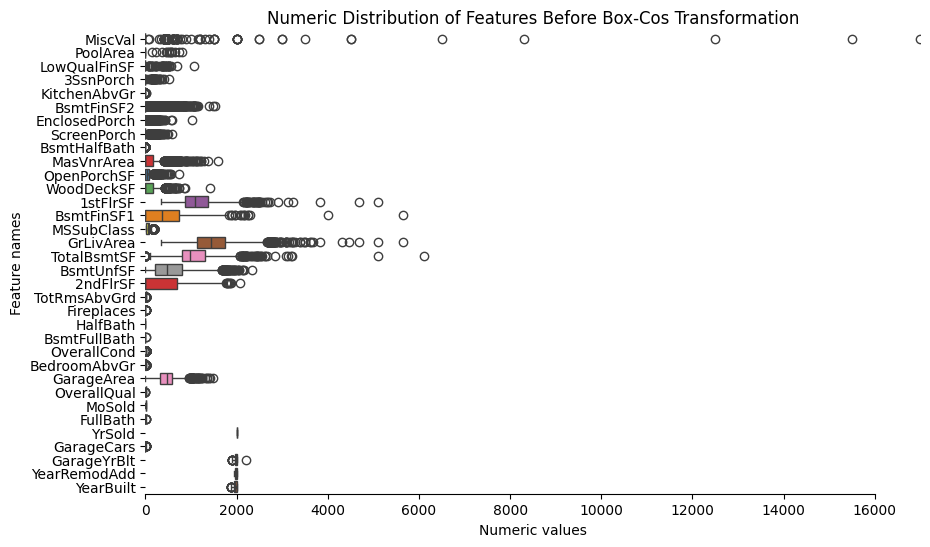

In [25]:
skewness_index=list(skew_features.index)
skewness_index.remove('LotArea') # 변수 LotArea의 값이 매우 커서 다른 변수들의 비대칭 분포도를 제대로 확인하기 어려워 제거
all_numeric_df = all_df.loc[:,skewness_index]

fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlim(0, all_numeric_df.max().sort_values(ascending = False)[0]) # all_numeric_df의 변수 값중 가장 큰 것들만 남기고 그 값들을 내림차순해서 그 중 첫 번째 값
ax=sns.boxplot(data=all_numeric_df[skewness_index], orient='h', palette = 'Set1')
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel='Numeric values')
ax.set(title='Numeric Distribution of Features Before Box-Cos Transformation')
sns.despine(trim=True, left=True)

시각화 결과, 왜도가 높아 이들을 바로 입력 변수로 활용하면 선형 회귀 알고리즘에서 입력값이 왜곡될 수 있음

이들의 왜도를 특정 기법을 이용해 변환하여 수치를 조정해주어야 함

왜도 조정 방법
1. 로그 변환
2. boxcox 변환


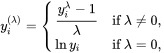

3. yeo-johnson 변환

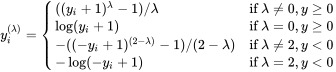

**박스콕스 변환(Box-Cox transformation)**

-> 양수인 데이터를 정규분포에 가깝게 만드는 방법

λ = 0 일때 , 데이터에 자연로그를 취한다.

λ ≠ 0 , 데이터 y를 λ만큼 거듭제곱한 후 1을 뺀 뒤, λ로 나눈다.​




\




**박스콕스 변환 과정**

1. 변환 파라미터(λ) 추정: 데이터에 대해서 변환 파라미터(λ)를 최적화한다. 보통 최대우도추정법이나 교차검증을 사용한다.
2. 데이터 변환


\


**박스콕스 변환 한계점**

데이터가 0 또는 음수 값을 가질 때 적용하기 어려움 👉  여존슨 변환(Yeo-Johnson transformation) 사용



---


**여존슨 변환(Yeo-Johnson transformation)**

-> 박스콕스 변환을 보완하고 음수 값을 가지는 데이터에도 적용할 수 있도록 확장된 변환이다.

\
데이터가 0 또는 양수일 경우,

λ= 0 인 경우: 데이터 y에 1을 더하고 λ만큼 거듭제곱한 후 1을 뺀 뒤, λ로 나눈다.
λ ≠ 0 인 경우: 데이터 y에 1을 더한 후 로그를 취한다.

\
데이터가 음수일 경우,

λ ≠ 2 인 경우: 데이터 y에 1을 빼고 2−λ 만큼 거듭제곱한 후 1을 뺀 뒤, 2−λ로 나눈다.
λ = 2 인 경우: 데이터 y에 1을 빼고 로그를 취한다.


In [26]:
from scipy.special import boxcox1p
from sklearn.preprocessing import PowerTransformer


high_skew = skew_features
high_skew_index = high_skew.index
print('the data before Log Transformation: \n', all_df[high_skew_index].head())


# 변환기 정의
pt = PowerTransformer(method='yeo-johnson', standardize=False)
all_df[high_skew_index] = pt.fit_transform(all_df[high_skew_index])

print('the data after Log Transformation: \n', all_df[high_skew_index].head())

the data before Log Transformation: 
    MiscVal  PoolArea  LotArea  LowQualFinSF  3SsnPorch  KitchenAbvGr  \
0        0         0     8450             0          0             1   
1        0         0     9600             0          0             1   
2        0         0    11250             0          0             1   
3        0         0     9550             0          0             1   
4        0         0    14260             0          0             1   

   BsmtFinSF2  EnclosedPorch  ScreenPorch  BsmtHalfBath  ...  BedroomAbvGr  \
0         0.0              0            0           0.0  ...             3   
1         0.0              0            0           1.0  ...             3   
2         0.0              0            0           0.0  ...             3   
3         0.0            272            0           0.0  ...             3   
4         0.0              0            0           0.0  ...             4   

   GarageArea  OverallQual  MoSold  FullBath  YrSold  Garage

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [27]:
all_df['TotalBsmtSF']

,TotalBsmtSF
0,213.753354
1,286.734160
2,225.745827
3,194.559991
4,266.391580
...,...
2912,152.028377
2913,152.028377
2914,280.180254
2915,224.258286


# 도출 변수 생성

In [28]:
# 집의 전체크기를 의미 하는 'TotalSF' 변수를 생성
all_df['TotalSF'] = all_df['TotalBsmtSF'] + all_df['1stFlrSF'] + all_df['2ndFlrSF']
all_df.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)
print(all_df.shape)

(2917, 70)


In [29]:
# 집의 전체 화장실 개수 Total_Bathrooms' 변수 생성
all_df['Total_Bathrooms'] = (all_df['FullBath'] + (0.5 * all_df['HalfBath']) +
                             all_df['BsmtFullBath'] + (0.5 * all_df['BsmtHalfBath']))

#집의 현관 개수 'Total_porch_sf' 변수 생성
all_df['Total_porch_sf'] = (all_df['OpenPorchSF'] + all_df['3SsnPorch'] +
                            all_df['EnclosedPorch'] + all_df['ScreenPorch'])

all_df = all_df.drop(['FullBath', 'HalfBath','BsmtFullBath','BsmtHalfBath','OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch'], axis=1)

print(all_df.shape)

(2917, 64)


In [30]:
# 연도와 관련있는 변수 추출
num_all_vars = list(train.select_dtypes(include = [np.number]))
year_feature = []
for var in num_all_vars:
    if 'Yr' in var:
        year_feature.append(var)
    elif 'Year' in var:
        year_feature.append(var)
    else:
        print(var, "is not related with year")

print(year_feature)

MSSubClass is not related with year
LotFrontage is not related with year
LotArea is not related with year
OverallQual is not related with year
OverallCond is not related with year
MasVnrArea is not related with year
BsmtFinSF1 is not related with year
BsmtFinSF2 is not related with year
BsmtUnfSF is not related with year
TotalBsmtSF is not related with year
1stFlrSF is not related with year
2ndFlrSF is not related with year
LowQualFinSF is not related with year
GrLivArea is not related with year
BsmtFullBath is not related with year
BsmtHalfBath is not related with year
FullBath is not related with year
HalfBath is not related with year
BedroomAbvGr is not related with year
KitchenAbvGr is not related with year
TotRmsAbvGrd is not related with year
Fireplaces is not related with year
GarageCars is not related with year
GarageArea is not related with year
WoodDeckSF is not related with year
OpenPorchSF is not related with year
EnclosedPorch is not related with year
3SsnPorch is not rela

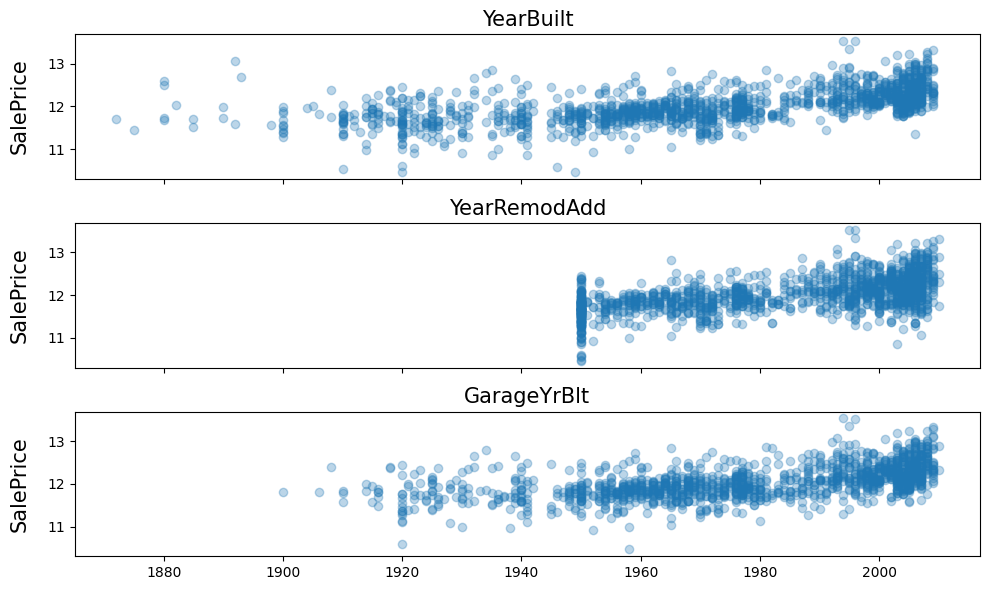

In [31]:
# 연도 관련 변수와 SalePrice를 연관지어 시각화하기
fig, ax = plt.subplots(3 , 1, figsize=(10,6), sharex = True, sharey=True) # subplot이 아닌 subplots를 써야함
for i, var in enumerate(year_feature):
    if var != 'YrSold':
        ax[i].scatter(train[var], y , alpha =0.3) # SalePrice가 train에만 있어서 train 데이터를 활용
        ax[i].set_title(f'{var}', size = 15)
        ax[i].set_ylabel('SalePrice', size = 15, labelpad = 12.5)

plt.tight_layout()
plt.show()

2000년대 올수록 SalePrice의 가격이 모두 우측으로 상향함을 알 수 있다.

보통 리모델링을 진행하면 주택 가격의 호가를 높여 부를 수 있어 리모델링만 기준삼고 나머지 변수는 삭제

In [32]:
# 리모델링을 기준삼고 나머지 변수는 삭제
all_df.drop(['YearBuilt','GarageYrBlt'], axis = 1, inplace = True)
print(all_df.shape)

(2917, 62)


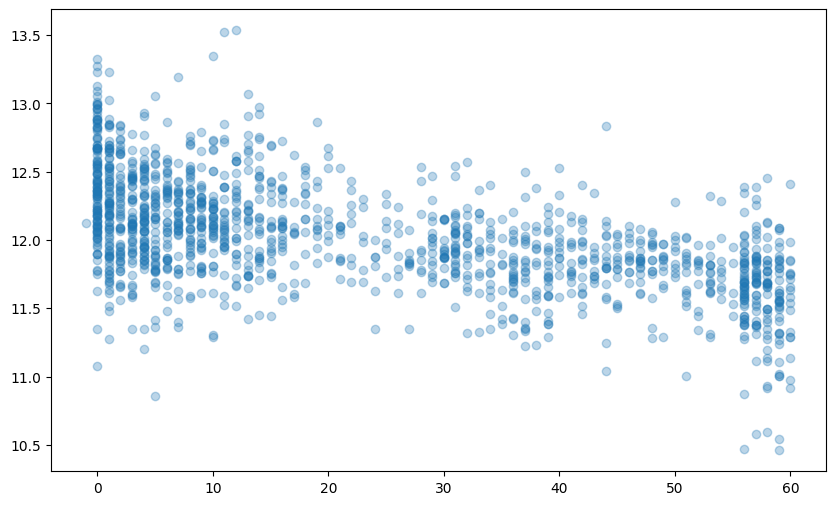

In [33]:
#YrSold와 YearRemodAdd 연도 차이 값에 대한 변수 YearSinceRemodel을 만든 후 시각화 진행
YearsSinceRemodel = train['YrSold'].astype(int) - train['YearRemodAdd'].astype(int)
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(YearsSinceRemodel, y, alpha=0.3)
fig.show()

차이가 커질수록 SalePrice 값이 하양함을 알 수 있다

In [34]:
all_df['YearsSinceRemodel'] = all_df['YrSold'].astype(int) - all_df['YearRemodAdd'].astype(int)
all_df = all_df.drop(['YrSold','YearRemodAdd'], axis = 1)
print(all_df.shape)

(2917, 61)


# 더미변수 생성

In [35]:
all_df['PoolArea'].value_counts()
# 확인 후 0보다 크면 1로, 0은 0으로 처리한다

,count
PoolArea,
-0.00000,2904
0.02738,13


In [36]:
# 0 보다 크면 1, 0이면 0으로 변환하는 사용자 함수 저으이
def count_dummy(x):
    if x>0:
        return 1
    else:
        return 0

all_df['PoolArea'] = all_df['PoolArea'].apply(count_dummy)
all_df['PoolArea'].value_counts()

,count
PoolArea,
0,2904
1,13


In [37]:
all_df['GarageArea'] = all_df['GarageArea'].apply(count_dummy)
all_df['GarageArea'].value_counts()

,count
GarageArea,
1,2760
0,157


In [38]:
all_df['Fireplaces'] = all_df['Fireplaces'].apply(count_dummy)
all_df['Fireplaces'].value_counts()

,count
Fireplaces,
1,1497
0,1420


In [39]:
#전체 데이터 원 핫 인코딩
all_df = pd.get_dummies(all_df).reset_index(drop=True)
print(all_df.shape)

(2917, 254)


# 머신러닝 모형 학습 및 평가

In [40]:
X = all_df.iloc[:len(y), :]
X_test = all_df.iloc[len(y):, :]
X.shape, y.shape, X_test.shape

((1458, 254), (1458,), (1459, 254))

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1166, 254), (292, 254), (1166,), (292,))

In [42]:
# 5-fold 교차검증
cv = KFold(n_splits = 5, random_state=0, shuffle=True)

# 회귀 모형 평가 - RMSE

회귀 모형에서 평가 지표는 오류(Error)

*Error = True value - Predicted Value*


---


**오차를 활용한 평가 방법**

1. MAE(Mean Abolute Error)

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$


\

2. MSE(Mean Squared Error)

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

\

3. RMSE(Root MEan Squared Error)

$$
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }
$$




---
캐글에서는 RMSE를 주로 평가 지표로 사용함

-> 1. 매우 쉽게 접근이 가능함. 오차의 값이 낮을수록 좋은 모형이지만 절대적인 기준이 없어 다양한 머신러닝 및 피처 엔지니어링을 반복하여 최대한 낮워야 함.

-> 2. 오차가 크면 RMSE값이 크게 흔들림. 즉 제대로 예측되지 않은 것을 직관적으로 확인할 수 있음

In [43]:
#RMSE는 별도의 함수가 내장되지 않아 MSE 모듈을 활용해 사용자 함수로 정의한다
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [44]:
# 교차검증을 할 때마다 RMSE를 확인하는 사용자 함수 정의
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression


def cv_rmse(model, n_folds = 5):
    cv = KFold(n_splits = n_folds, random_state=42, shuffle=True)
    rmse_list = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv))
    print('CV RMSE value list:',np.round(rmse_list, 4))
    print('CV RMSE value mean:',np.round(np.mean(rmse_list), 4))
    return rmse_list


# 각각의 RMSE를 리스트로 반환받은 뒤 딕셔너리 rmse_scores에 입력
n_folds = 4 # n_folds = 5일 때보다 4일 때 정확도가 더 높게 나와서 여기서는 4로 지정하였음
rmse_scores = {}
lr_model=LinearRegression()

score = cv_rmse(lr_model, n_folds)
print('linear regression-mean: {:.4f} (std: {:.4f})'.format(score.mean(), score.std()))
rmse_scores['LinearRegression'] = (score.mean(), score.std()) # rmse_score 딕셔너리에 값 추가

CV RMSE value list: [0.1693 0.5867 0.1486 0.1221]
CV RMSE value mean: 0.2567
linear regression-mean: 0.2567 (std: 0.1913)


# 최종 예측 제출

In [45]:
from sklearn.model_selection import cross_val_predict

X = all_df.iloc[:len(y), :]
X_test = all_df.iloc[len(y):, :]
X.shape, y.shape, X_test.shape

lr_model_fit = lr_model.fit(X,y)
final_preds = np.floor(np.expm1(lr_model_fit.predict(X_test))) # np.log1p 변환을 하였기에 원래 값으로 돌릴 때 np.expm1을 사용한다 // np.floor는 소수점 이하는 표시하지 않음 실제 매매 가격은 소수점 이하는 표시하지 않기 때문
print(final_preds)

[114715. 162538. 189681. ... 176335. 114009. 217454.]


In [46]:
submission = pd.read_csv('/content/sample_submission.csv')
submission.iloc[:,1] = final_preds # 실제 예측값인 final_preds 추가
print(submission.head())
submission.to_csv('1st_regression.csv', index = False)

     Id  SalePrice
0  1461   114715.0
1  1462   162538.0
2  1463   189681.0
3  1464   200371.0
4  1465   196354.0


# 모형 알고리즘 추가

In [47]:
# 모형의 성능 개선을 위해 Decision Tree, Random Forest, GBM 모형 추가
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

#LinearRegression
lr_model = LinearRegression()

#Tree Decision
tree_model = DecisionTreeRegressor()

#Random Foreset Regressor
rf_model = RandomForestRegressor()

#Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor()

In [48]:
# Decision Tree, Random Forest, GBM 모형을 각각 cv_rmse에 적용해 값을 구한다
score = cv_rmse(tree_model, n_folds = 5)
print("Decision Tree Regressor-mean: {:.4f} (std: {:.4f})".format(score.mean(), score.std()))
rmse_scores['Decision Tree Regressor'] = (score.mean(), score.std())

CV RMSE value list: [0.2337 0.2056 0.2132 0.2082 0.2126]
CV RMSE value mean: 0.2147
Decision Tree Regressor-mean: 0.2147 (std: 0.0099)


In [49]:
score = cv_rmse(rf_model, n_folds = 5)
print("RandomForeset Regressor-mean: {:.4f} (std: {:.4f})".format(score.mean(), score.std()))
rmse_scores['RandomForest Regressor'] = (score.mean(), score.std())

CV RMSE value list: [0.1577 0.147  0.1342 0.1625 0.1355]
CV RMSE value mean: 0.1474
RandomForeset Regressor-mean: 0.1474 (std: 0.0114)


In [50]:
score = cv_rmse(gbr_model, n_folds = 5)
print("Gradient Boosting Regressor-mean: {:.4f} (std: {:.4f})".format(score.mean(), score.std()))
rmse_scores['Gradient Boosting Regressor'] = (score.mean(), score.std())

CV RMSE value list: [0.1372 0.1354 0.1229 0.1359 0.1233]
CV RMSE value mean: 0.1309
Gradient Boosting Regressor-mean: 0.1309 (std: 0.0064)


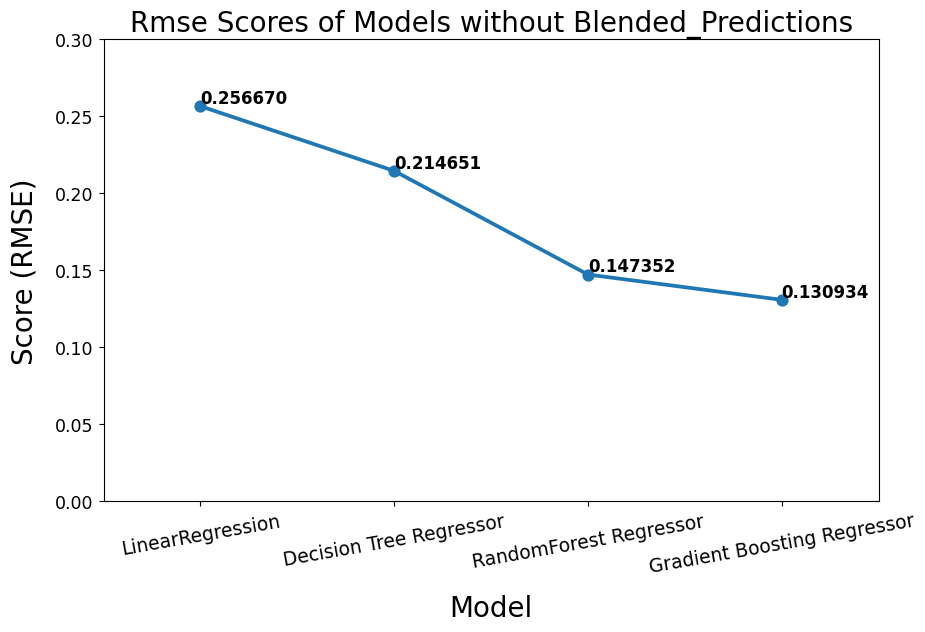

In [51]:
#시각화를 통해 어떤 머신러닝 알고리즘이 가장 낮은 RMSE를 기록하는지 확인
fig, ax = plt.subplots(figsize=(10,6))

ax=sns.pointplot(x=list(rmse_scores.keys()), y = [score[0] for score in rmse_scores.values()], ax=ax)
for i, score in enumerate(rmse_scores.values()):
    ax.text(i, score[0]+0.002, '{:6f}'.format(score[0]), horizontalalignment = 'left', size = 'large', color = 'black', weight = 'semibold')

ax.set_ylabel('Score (RMSE)', size = 20, labelpad=12.5)
ax.set_xlabel('Model', size = 20, labelpad=12.5)
ax.tick_params(axis = 'x', labelsize = 13.5, rotation = 10)
ax.tick_params(axis = 'y', labelsize = 12.5)
ax.set_ylim(0, 0.3)
ax.set_title("Rmse Scores of Models without Blended_Predictions", size = 20)
fig.show()

# Blending - 가중치를 모형에 부과

In [52]:
# Blending 적용하기

lr_model_fit = lr_model.fit(X, y)
tree_model_fit = tree_model.fit(X, y)
rf_model_fit = rf_model.fit(X, y)
gbr_model_fit = gbr_model.fit(X, y)


# Blending 적용 사용자 함수 정의

def blended_learning_predictions(X):
    blended_score=(0.3*lr_model_fit.predict(X))+\
    (0.2*tree_model_fit.predict(X))+\
    (0.2*rf_model_fit.predict(X))+\
    (0.3*gbr_model_fit.predict(X))
    return blended_score

In [53]:
blended_score = rmse(y, blended_learning_predictions(X))
rmse_scores['blended']= (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.05946215097607764


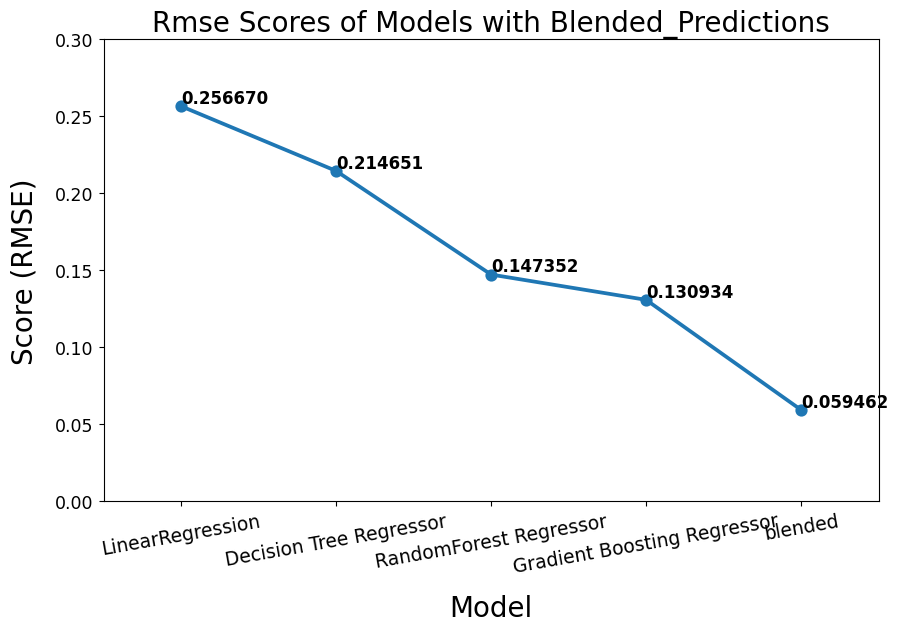

In [54]:
#시각화를 통해 어떤 머신러닝 알고리즘이 가장 낮은 RMSE를 기록하는지 확인
fig, ax = plt.subplots(figsize=(10,6))

ax=sns.pointplot(x=list(rmse_scores.keys()), y = [score[0] for score in rmse_scores.values()], ax=ax)
for i, score in enumerate(rmse_scores.values()):
    ax.text(i, score[0]+0.002, '{:6f}'.format(score[0]), horizontalalignment = 'left', size = 'large', color = 'black', weight = 'semibold')

ax.set_ylabel('Score (RMSE)', size = 20, labelpad=12.5)
ax.set_xlabel('Model', size = 20, labelpad=12.5)
ax.tick_params(axis = 'x', labelsize = 13.5, rotation = 10)
ax.tick_params(axis = 'y', labelsize = 12.5)
ax.set_ylim(0, 0.3)
ax.set_title("Rmse Scores of Models with Blended_Predictions", size = 20)
fig.show()

# 진짜 최종 예측 제출

In [55]:
submission = pd.read_csv('/content/sample_submission.csv')
submission.iloc[:,1] = np.floor (np.expm1(blended_learning_predictions(X_test))) # 수정된 예측값 추가
print(submission.head())
submission.to_csv('2nd_regression.csv', index = False)

     Id  SalePrice
0  1461   117341.0
1  1462   155328.0
2  1463   187315.0
3  1464   193092.0
4  1465   195762.0
